# Chapter 13: DSC/DCE MRI ANALYSIS

### This is "worked example"  walking through an example pipeline (as illustrated in Fig. 2) for DSC/DCE MRI analysis of a dual echo EPI acquisition.

## 1. Import all the necessary packages

In [1]:
import os
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from numpy.linalg import svd
%matplotlib inline

## 2. Load Data, define imaging parameters, set perfusion constants
In this example, we assume a dual-echo EPI acquistion to demonstrate how both DSC and DCE parameters may be computed using the most common methods. 


### 2.1 Define known imaging parameters shortest echo time ($TE_1$ \[sec\]), longest echo time ($TE_2$ \[sec\]), TR [sec], and flip angle [degrees].

In [2]:
signaltimecurves = scipy.io.loadmat('Chapter13_JupyterNtBk_data.mat')

TE1 = np.squeeze(signaltimecurves['TE1']) # in seconds
TE2 = np.squeeze(signaltimecurves['TE2']) # in seconds
TR = np.squeeze(signaltimecurves['TR'])   # in seconds
flip = np.squeeze(signaltimecurves['flip']) # in degrees

nt = 121; # number of time points
timeArray = TR*np.arange(nt)

print('This dual-echo acquisition was acquired with the following parameters: ')
print('TR = ' +str(TR*1000)+ ' ms')
print('TE1 = ' +str(TE1*1000)+ ' ms')
print('TE2 = ' +str(TE2*1000)+ ' ms')
print('Flip Angle = ' +str(flip)+ ' deg')

This dual-echo acquisition was acquired with the following parameters: 
TR = 1500.0 ms
TE1 = 2.0 ms
TE2 = 30.0 ms
Flip Angle = 60 deg


### 2.2 Load MR signal intensity $SI_t$ time curves, compute $SI_t$ at TE = 0, and load a population-based AIF concentration curves ($C_t$).
This example uses a representative signal time course for three regions: brain tumor, normal-appearing-white-matter (NAWM), and arterial input function (AIF). 

From the measured MR data, user needs to determine the baseline (precontrast) time points of these curves.

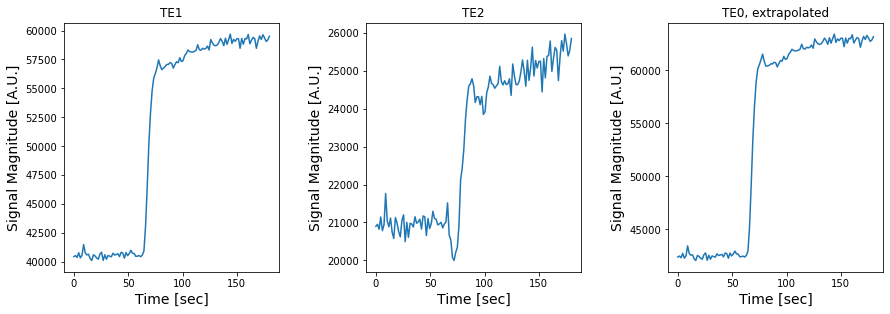

In [3]:
tumor_SIt = signaltimecurves['tumor_SIt'] #measured tumor signal time curves
NAWM_SIt = signaltimecurves['NAWM_SIt'] #measured NAWM signal time curves
AIF_SIt = signaltimecurves['AIF_SIt'] #measured NAWM signal time curves

basepts = [0, 40] #define pre-contrast baseline points

# here we correct for T2* effects such that the signal time curve can be extrapolated back to TE=0
R2s = (1/(TE2 - TE1)) * np.log(tumor_SIt[0,:] / tumor_SIt[1,:])
tumor_SIt_TE0 = tumor_SIt[0,:] * np.exp(TE1*R2s)

#Plot Signal curves
fig, axs = plt.subplots(1, 3, figsize=(13,5))
axs[0].plot(timeArray, tumor_SIt[0,:])
axs[0].set_title('TE1')
axs[0].set_xlabel('Time [sec]', fontsize=14)
axs[0].set_ylabel('Signal Magnitude [A.U.]', fontsize=14)

axs[1].plot(timeArray, tumor_SIt[1,:])
axs[1].set_title('TE2')
axs[1].set_xlabel('Time [sec]', fontsize=14)
axs[1].set_ylabel('Signal Magnitude [A.U.]', fontsize=14)

axs[2].plot(timeArray, tumor_SIt_TE0)
axs[2].set_title('TE0, extrapolated')
axs[2].set_xlabel('Time [sec]', fontsize=14)
axs[2].set_ylabel('Signal Magnitude [A.U.]', fontsize=14)

fig.tight_layout(pad=3.0)
_ = plt.show()

In the above graph, notice the conventional signal drop due to the arrival of gadolinium at $TE_2$, but then how the post-contrast time points overshoot the pre-contrast SI time points due to a disrupted-BBB (middle plot). With a shorter $TE_1$ (left plot), this signal drop is not observed and a T1-weighted signal time curve is seen due to the disrupted-BBB. Since this is a multi-echo acquisition, this DCE curve can be corrected for T2* effects through extrapolating back to a $TE_0$ (0 sec) (right plot). See that the signal magnitude of this curve is higher than both $TE_1$ and $TE_2$.


## 3. Do DSC Perfusion Analysis (CBV, CBF, MTT)

### 3.1 Calculate $\Delta R_2(t)^*$ curves 
- $\Delta R_2(t)^*$ time curves can be calculated for single echo acquisitions as:
<center><br>$\Delta R_2^*(t)$ = $\frac{-1}{TE}ln(\frac{S(t)}{S_0})$,</center>
<br>where $S_0$ is the average baseline signal prior to bolus arrival.<br> 



- $\Delta R_2(t)^*$ time curves can be calculated for dual echo (DE) acquisitions as:<br>
<center><br>$\Delta R_2^*(t)$ = $\frac{-1}{\Delta TE}ln(\frac{S_{TE1}(t)/S_{0, TE1}}{S_{TE2}(t)/S_{0, TE2}})$,</center>
<br>where $\Delta TE$ is the difference between the echo times, and $S_{0,TEx}$ is the average baseline signal prior to bolus arrival for each echo time (x = 1,2).


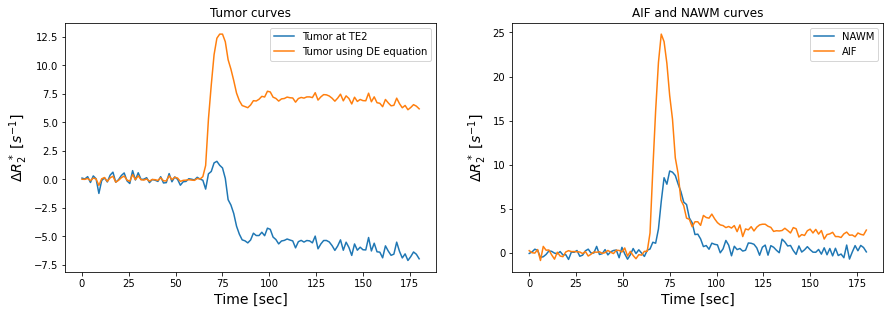

In [4]:
dR2s_tumor_TE1 = (-1/TE1) * (np.log(tumor_SIt[0,:] / np.mean(tumor_SIt[0,basepts[0]:basepts[1]],axis=-1) ))
dR2s_tumor_TE2 = (-1/TE2) * (np.log(tumor_SIt[1,:] / np.mean(tumor_SIt[1,basepts[0]:basepts[1]],axis=-1) ))
dR2s_tumor_DE = (1/(TE2 - TE1)) * (np.log((tumor_SIt[0,:] / np.mean(tumor_SIt[0,basepts[0]:basepts[1]],axis=-1)) / (tumor_SIt[1,:] / np.mean(tumor_SIt[1,basepts[0]:basepts[1]],axis=-1))))

dR2s_NAWM_TE2 = (-1/TE2) * (np.log(NAWM_SIt[1,:] / np.mean(NAWM_SIt[1,basepts[0]:basepts[1]],axis=-1) )) 
dR2s_AIF = (-(1/TE1)) * (np.log(AIF_SIt[0,:] / np.mean(AIF_SIt[0,basepts[0]:basepts[1]],axis=-1) ))

#Plot curves
fig, axs = plt.subplots(1, 2, figsize=(13,5))
axs[0].plot(timeArray, dR2s_tumor_TE2, label='Tumor at TE2')
axs[0].plot(timeArray, dR2s_tumor_DE, label='Tumor using DE equation')
axs[0].set_title('Tumor curves')
axs[0].set_xlabel('Time [sec]', fontsize=14)
axs[0].set_ylabel('$\Delta R_2^*$ [$s^{-1}$]', fontsize=14)
axs[0].legend()

axs[1].plot(timeArray, dR2s_NAWM_TE2, label='NAWM')
axs[1].plot(timeArray, dR2s_AIF, label='AIF')
axs[1].set_title('AIF and NAWM curves')
axs[1].set_xlabel('Time [sec]', fontsize=14)
axs[1].set_ylabel('$\Delta R_2^*$ [$s^{-1}$]', fontsize=14)
axs[1].legend()

fig.tight_layout(pad=3.0)
_ = plt.show()

In the left graph, notice the $T_1$ leakage effects in TE2 (much more dramatic for TE1 but not shown for y-axis scaling) of the $\Delta R_2^*(t)$. If CBV were to be computed now, the values would be negative and thus physiologically impossible. However, these $T_1$ leakage effects are not seen in the dual-echo equation (but note that a dual echo $\Delta R_2^*(t)$ may still have competing $T_2^*$ effects). All tumor curves whether computed at TE1, TE2, or with the dual-equation still need a leakage correction method applied during post-processing (see next section).

In the right graph, the $\Delta R_2^*(t)$ curves are shown for the NAWM and AIF. These curves are considered to be within healthy tissue (intact-BBB) regions, so leakage correction will not need to be applied.

### 3.2 Apply Leakage Correction. 
Here we apply the Boxerman-Schmainda-Weiskoff (BSW) leakage correction method that accounts for both $T_1$ and $T2^*$ effects (PMID: 16611779). We will apply it to 1) $\Delta R_2^*(t)$ at $TE_2$ (this represents a conventional EPI acquisition time) and 2) the dual-echo $\Delta R_2^*(t)$ to correct for possible $T_2^*$ leakage effects. Note that only the tumor pixels are corrected for leakage and the NAWM assumed to be the "whole brain non-enhancing region" (WBNE) required by the BSW approach.

(121,)


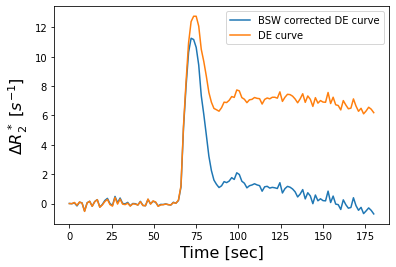

In [5]:
# Define the BSW leakage correction function
def BSWfunction(X,k1,k2):
    dR2s_tumor_WBNE,dR2s_WBNEint = X
    return k1*dR2s_tumor_WBNE - k2*dR2s_WBNEint

# Correct for possible T2* leakage in the DE curve
p0 = 1.,0. #initial guess for fit
dR2s_WBNE = dR2s_NAWM_TE2 #define WBNE


#DEBUG - END
#-------------
BSW_kvals,BSW_fitcov = curve_fit(BSWfunction,(dR2s_WBNE,np.cumsum(dR2s_WBNE)),dR2s_tumor_DE,p0);
K1_dR2s = BSW_kvals[0];
K2_dR2s = BSW_kvals[1];
leakage = np.multiply(-K2_dR2s, np.cumsum(dR2s_WBNE));
dR2s_tumor_BSW_DE = dR2s_tumor_DE - leakage;

print(dR2s_tumor_BSW_DE.shape)
# Generate ∆R2* plots
plt.plot(timeArray, dR2s_tumor_BSW_DE, label='BSW corrected DE curve')
plt.plot(timeArray, dR2s_tumor_DE, label='DE curve')
plt.xlabel('Time [sec]', fontsize=16)
plt.ylabel('$\Delta R_2^*$ [$s^{-1}$]', fontsize=16)
plt.legend()

plt.show()

In this above graph, note how the BSW corrected tumor curve now returns close to baseline signal - indicating that there is competing T2* leakage effects in the raw tumor curve.

### 3.3 Compute DSC Parameters: CBV, CBF, MTT
Computing the DSC parameters involves performing a deconvolution through two analysis steps. The first step in performing deconvolution is the discretization of the AIF. A detailed comparison of some of the discretization methods implemented in literature has been provided by Soubron et al. (DOI:10.1088/0031-9155/52/22/014) -- including those they are less sensitive to AIF delay and dispersion. The second step is the regularization choice to ensure both a mathematically and physiological result is found as described by Sourbon et al. (DOI:10.1088/0031-9155/52/2/009). Based on these articles, we have implemented a Volterra discretization with L-curve criterion for regularization to demonstrate derivation of of the residue function needed for CBF and MTT calculations.

- CBF is numerically calculated as the maximum value of the tissue residue function $R(t)$, where $R(t)$ is related to the tissue concentration $C(t)$, and the AIF $C_a(t)$ by: $C(t)$ = $F.C_a(t) * R(t)$
- CBV is numerically calculated as the area under the curve of the $\Delta R_2^*$ time curve
- MTT is numerically calculated as the ratio of CBV and CBF based on the Central Volume Theorem


Assumptions:
 - While calculating CBF, tissue concentration is linearly dependent on $\Delta R_2^*$. We have assumed that the constant of proportionality is 1. Therefore, the AIF and tumor $\Delta R_2^*$ values are used to compute tissue residue function $R(t)$


In [7]:
# Discretize the AIF 
A_mtx = np.zeros([nt,nt])
for i in range(nt):
    for j in range(nt):
        if j == 0 and i != 0:
            A_mtx[i,j] = (2 * dR2s_AIF[i] + dR2s_AIF[i-1])/6.
        elif i == j:
            A_mtx[i,j] = (2 * dR2s_AIF[0] + dR2s_AIF[1])/6.
        elif 0<j and j<i:
            A_mtx[i,j] = ((2 * dR2s_AIF[i-j] + dR2s_AIF[i-j-1])/6) +((2 * dR2s_AIF[i-j] + dR2s_AIF[i-j+1])/6)
        else:
            A_mtx[i,j] = 0.
            
# Singular value Decomposition (SVD) without regularization
A_mtx = TR * A_mtx
B0 = dR2s_tumor_BSW_DE

U,S,V = svd(A_mtx)
S_d = np.diag(S)
B = np.transpose(U) @ B0

In [8]:
# Start L-curve regularization to get optimal mu used for regularization
def lcurvereg(A_mtx,B,U):
    umax = 10.
    umin = 10E-10
    nu = 400
    k = np.arange(nu)
    u = np.amax(S) * umin * np.power((umax/umin),((k-1)/(nu-1)))

    l_0 = np.zeros([nu,A_mtx[:,0].size])
    l_1 = np.zeros([nu,A_mtx[:,0].size])
    l_2 = np.zeros([nu,A_mtx[:,0].size])
    L = np.zeros([nu,A_mtx[:,0].size,3])
    for x in range(nu):
        for y in range(A_mtx[:,0].size):
            l_0[x,y] = np.power((np.power(u[x],2) / (np.power(S[y],2) + np.power(u[x],2))),2)
            l_1[x,y] = np.power((S[y] / (np.power(S[y],2) + np.power(u[x],2))),2)
            l_2[x,y] = ((-4)*u[x]*np.power(S[y],2)) / np.power((np.power(S[y],2) + np.power(u[x],2)),3)

    L[:,:,0] = l_0
    L[:,:,1] = l_1
    L[:,:,2] = l_2

    # Start LCCOPTIMIZE
    k = (nu - 1)-1
    m = np.zeros([nu,3])
    product = np.zeros(A_mtx[:,0].size)
    L_curve = np.zeros(nu)

    for x in range(A_mtx[:,0].size):
        U_i = U[:,x]
        product[x] = np.power((np.transpose(U_i) @ B),2)

    for x in range(3):
        l_tmp = L[:,:,x]
        m[:,x] = np.sum(l_tmp,axis=1)*np.sum(product)

    for x in range(nu):
        L_curve[x] = 2 * (m[x,1] * m[x,0] / m[x,2]) * ((np.power(u[x],2) * m[x,2] * m[x,0] + 2 * u[x] * m[x,1] *m[x,0] + 
                                                        np.power(u[x],4) * m[x,1] * m[x,2]) / np.power((np.power(u[x],4) * 
                                                        np.power(m[x,1],2) + np.power(m[x,0],2)),(3/2)));

    L_minus1 = L_curve[k-2]
    L_0 = L_curve[k-1]
    L_1 = L_curve[k]

    while L_0 >= L_minus1 or L_0 >= L_1:
        k = k - 1
        if k == 0:
            mu_opt = umax
            break

        L_1 = L_0
        L_0 = L_minus1
        L_minus1 = L_curve[k-1]
        mu_opt = u[k-1]
    return mu_opt

mu_opt = lcurvereg(A_mtx,B,U)    
print('The optimal mu for regularization using an L-curve criterion method is: ' +str(f'{mu_opt:.1f}'))

The optimal mu for regularization using an L-curve criterion method is: 81.8


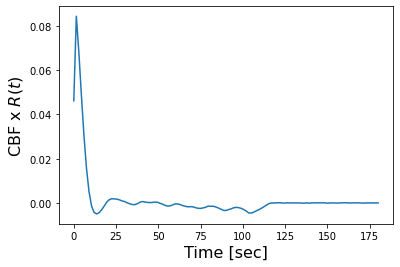

Perfusion parameters are as follows:
CBF = 337.6 mL/100 mL/min
CBV = 38.2 mL/100 mL
MTT = 6.8 s


In [9]:
# Regularize the outputs of the SVD using the L-curve criterion
Bpi = np.multiply(B,np.divide(S,(np.power(S,2) + np.power(mu_opt,2))))
residualFunction = np.transpose(V) @ Bpi

# Calculate CBF, CBV and MTT
CBF = np.amax(residualFunction)/TR * 60 * 100 
CBV = np.trapz(dR2s_tumor_BSW_DE) / np.trapz(dR2s_AIF) * 100 
MTT = CBV / CBF * 60 

# Generate residue function curve
plt.plot(timeArray, residualFunction)
plt.xlabel('Time [sec]', fontsize=16)
plt.ylabel('CBF x $R(t)$', fontsize=16)

plt.show()

print('Perfusion parameters are as follows:')
print('CBF = '+str(f'{CBF:.1f}')+' mL/100 mL/min')
print('CBV = '+str(f'{CBV:.1f}')+' mL/100 mL')
print('MTT = '+str(f'{MTT:.1f}')+' s')

## 4. Do DCE Analysis ($K^{trans}$, $v_e$)
### 4.1 Define <em>a priori</em> perfusion constants for the DCE analysis (precontrast T1 and longitudinal relaxivity $r_1$) and load provided AIF concentration curve

In [15]:
tumor_T1 = np.squeeze(signaltimecurves['tumor_T1']) # measured in separate scan before perfusion scan
NAWM_T1 = np.squeeze(signaltimecurves['NAWM_T1']) # measured in separate scan before perfusion scan
r1 = 3.3  # longitudinal relaxivity of Gd-DTPA at 3T [1/mM.s], typically defined by literature

AIF_Ct = signaltimecurves['AIF_Ct'] #The AIF is a population-based AIF (see DOI: 10.1002/mrm.21066).
flip_rad = np.deg2rad(flip) #convert degrees to radians

### 4.2 Calculate $\Delta R_1(t)$ and concentration $C_t$
- The baseline signal $S_0$ is obtained as the average of measured signal prior to bolus arrival
- The longitudinal relaxation rate $R_1(t)$ is obtained as outline by the Quantitative Imaging Biomarker Alliance (QIBA):
<center>$R_1(t)$ = $\frac{-1}{TR}ln(\frac{1 - A}{1 - cos \alpha * A})$</center>
where $\alpha$ is the flip angle and $A$ is given as 
<center>$A$ = $\frac{1 - E_{10}}{1 - cos \alpha * E_{10}} * \frac{SI(t)}{SI(0)}$</center>
and $E_{10}$ is the exponential term associated with T1 relaxation and calculated as
<center>$E_{10}$ = $e^{\frac{-TR}{T_{10}}}$</center>
- $\Delta R_1$ can then be obtained as:
<center>$\Delta R_1$ = [$\frac{1}{T_1(t)} - \frac{1}{T_{10}}$]</center>
- The concentration $C(t)$ is numerically calculated as 
<center>$C(t)$ = $\frac{\Delta R_1}{r_1}$</center>,
where $r_1$ is the longitudinal relaxivity of the contrast agent and for this example is assumed to be 

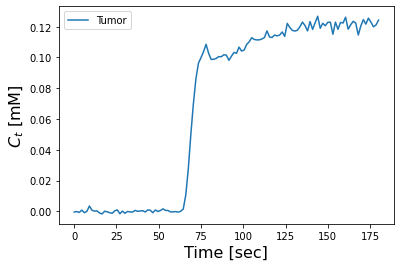

In [17]:
S0_TE0 = np.mean(tumor_SIt_TE0[basepts[0]:basepts[1]],axis=-1)
R10 = 1 / tumor_T1
S0 = ((np.exp(-R10 * TR) * np.cos(np.deg2rad(flip)) * S0_TE0) - S0_TE0 / np.sin(np.deg2rad(flip))) / (np.exp(-R10 * TR) - 1.)

a = np.sin(flip_rad)*S0 - tumor_SIt_TE0
b = np.sin(flip_rad)*S0 - np.cos(flip_rad)*tumor_SIt_TE0
c = np.sin(flip_rad)*S0 - np.cos(flip_rad)*S0_TE0
d = np.sin(flip_rad)*S0 - S0_TE0

dR1 = (-1/TR) * np.log((a / b) * (c / d))
tumor_Ct = dR1/r1

# Plot the concentration curve over time
plt.plot(timeArray, tumor_Ct,label='Tumor')
plt.xlabel('Time [sec]', fontsize=16)
plt.ylabel('$C_t$ [mM]', fontsize=16)
plt.legend()
plt.show()


### 4.3 Fit Standard Tofts Model
The contrast agent concentration in the tissue given by $C(t)$ is obtained using the model proposed by Tofts et al (DOI:10.1002/(sici)1522-2586(199909)10:3<223::aid-jmri2>3.0.co;2-s) as follows:
<center>$C_t(t)$ = $K^{trans}\int_{0}^{t} C_p(t)e^{\frac{-K^{trans}}{v_e}(T-t)}dt$</center>

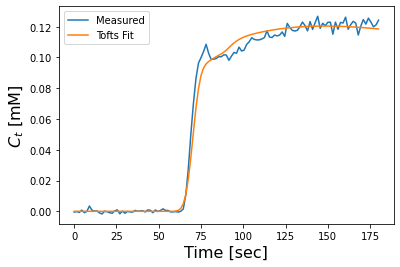

General Tofts Model fit results: 
Ktrans = 0.1174 1/min
ve = 0.147


In [23]:
# Define the General Tofts Model function
def modeltofts(X, Ktrans, ve):
    Cp, time_tau = X
    Ct = np.zeros_like(time_tau)
    for tau in range(time_tau.size):
        t = time_tau[0:tau+1]
        Cp_t = Cp[0:tau+1]
        Cp_t_exp = Cp_t * np.exp((-Ktrans / ve) * (t[-1] - t))
        if tau == 0:
            Ct[tau] = Ktrans * 0
        else:
            M = np.trapz(Cp_t_exp, t)
            Ct[tau] = Ktrans * np.trapz(Cp_t_exp, t)
    return Ct

# Fit tissue concentration curve to the Tofts model
p0 = 0.0002,0.1
tofts_fitval,tofts_fitcov = curve_fit(modeltofts,(AIF_Ct[0,:],timeArray),tumor_Ct,[2.E-4,0.2], bounds=([1.E-7,0.01], [2,1]))
fit_tmp = modeltofts((AIF_Ct[0,:],timeArray),tofts_fitval[0],tofts_fitval[1])

# Plot fits
plt.plot(timeArray, tumor_Ct,label='Measured')
plt.plot(timeArray, fit_tmp,label='Tofts Fit')
plt.xlabel('Time [sec]', fontsize=16)
plt.ylabel('$C_t$ [mM]', fontsize=16)
plt.legend()
plt.show()

print('General Tofts Model fit results: ')
print('Ktrans = '+str(f'{tofts_fitval[0]*60:.4f}')+' 1/min')
print('ve = '+str(f'{tofts_fitval[1]:.3f}'))

In [25]:
print(fit_tmp.shape)

(121,)
